In [1]:
%matplotlib inline

import matplotlib
matplotlib.style.use('seaborn-whitegrid')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import MiniBatchKMeans,KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import cdist,euclidean
from sklearn.preprocessing import normalize, StandardScaler,MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn import svm

rst = re.compile('RST*')

import math

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
bro = pd.read_csv(filepath_or_buffer='./dados/conn.log',sep='\t',\
                  header=0)

In [36]:
bro['label'].unique()

array(['none', 'nmap_sT_1000_T3', 'nmap_vo', 'nmap_probe_net',
       'nmap_syn_1000_t3', 'nmap_probe_host', 'nmap_syn_100_t2', 'nikto',
       'ftp_bruteforce', 'cewl', 'ssh_bruteforce'], dtype=object)

In [37]:
def label_attack(x):
    if x == 'T':
        return True
    else:
        return False

In [39]:
bro['attack'].value_counts()

F    42567
T     9538
Name: attack, dtype: int64

In [40]:
bro['attack'] = bro['attack'].apply(label_attack)
bro['ts'] = bro['ts'].apply(math.floor)

bro = bro.replace('-',0)
bro['duration'] = bro['duration'].astype(float)

bro = bro.sort_values('ts')

offset =  bro['ts'].head(1).values[0]

interval = 30

bro['group'] = (bro['ts'] - offset) // interval

group = bro.groupby(['group','id.orig_h'])

In [44]:
def total_rst(x):
    s = 0
    for v in x:
        if rst.match(v) or v in 'REJ': 
            
            s = s + 1
        
    return s

def total_null(x):
    s = 0
    for v in x:
        if v == 0:
            s = s + 1
            
    return s

In [45]:
ag = pd.DataFrame()

In [46]:
ag['total_conn'] = group['id.resp_h'].count()
ag['dist_dstaddr'] = group['id.resp_h'].nunique()
ag['dist_dstport'] = group['id.resp_p'].nunique()
ag['duration_avg'] = group['duration'].mean()
ag['src_pkts_avg'] = group['orig_pkts'].mean()
ag['src_bytes/pkts'] = group['orig_ip_bytes'].sum() / group['orig_pkts'].sum()
ag['total_dst_null'] = group.agg({'resp_ip_bytes': lambda x: total_null(x)})
ag['total_rst'] = group.agg({'conn_state': lambda x: total_rst(x)})

ag['label'] = group.agg({'attack': lambda x: x.any()})
ag['class'] = group['label'].agg(lambda x: x.value_counts().index[0])


In [53]:
ag = ag[ag.notnull().all(axis=1)]


In [54]:
ag['label'].value_counts()

False    10132
True        70
Name: label, dtype: int64

In [55]:
ag['class'].value_counts()

none                10132
ssh_bruteforce         21
ftp_bruteforce         20
nmap_vo                10
nmap_probe_net          7
nmap_syn_100_t2         4
nmap_probe_host         3
nikto                   2
cewl                    1
nmap_sT_1000_T3         1
nmap_syn_1000_t3        1
Name: class, dtype: int64

In [56]:
numerical_features = ag.columns[:-2]

In [57]:
len(ag)

10202

In [58]:
ag[numerical_features].describe()

,total_conn,dist_dstaddr,dist_dstport,duration_avg,src_pkts_avg,src_bytes/pkts,total_dst_null,total_rst
count,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000
mean,5.107234,1.518624,1.828759,20.719090,20.207208,128.559691,0.865517,0.819741
std,30.881229,1.958419,19.490249,177.273615,183.354220,568.832938,20.138160,18.774970
min,1.000000,1.000000,1.000000,0.000000,1.000000,28.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000565,1.000000,60.666667,0.000000,0.000000
50%,2.000000,1.000000,1.000000,0.079251,2.000000,69.250000,0.000000,0.000000
75%,3.000000,1.000000,1.000000,2.820167,6.000000,135.000000,1.000000,0.000000
max,2012.000000,85.000000,1002.000000,5940.092418,12089.000000,54047.913607,1977.000000,1081.000000


In [59]:
print(numerical_features)

Index(['total_conn', 'dist_dstaddr', 'dist_dstport', 'duration_avg',
       'src_pkts_avg', 'src_bytes/pkts', 'total_dst_null', 'total_rst'],
      dtype='object')


In [60]:
def plot_PCA(X, dblabels, chunk_labels):   
    pca_2 = PCA(2)

    plot_columns = pca_2.fit_transform(X)

    plt.figure(figsize=(20,20))

    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=dblabels)


    for lb, x, y in zip(chunk_labels, plot_columns[:,0],plot_columns[:,1]):
        plt.annotate(
            lb,
            xy = (x,y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0',facecolor='black'))

    plt.show()

In [61]:
import numpy as np

def fK(k, X, Skm1=0):
    """
    Computes f(K) proposed by Pham et al. 2004
    
    """
    d = len(X[0])
    
    a = lambda k, d: 1.0 - 3.0 / (4.0*d) if k == 2 \
        else a(k-1, d) + (1.0-a(k-1,d))/6.0
    
    estimator = MiniBatchKMeans(n_clusters=k, random_state=10, 
                                init='k-means++')
    estimator.fit_predict(X)
    Sk = estimator.inertia_
        
    if k == 1:
        f = 1
    if Skm1 == 0:
        f = 1
    else:
        f = Sk/(a(k,d)*Skm1)  
    
    return f, Sk


def testfK(maxk, X):
    ks = range(1,maxk+1)
    fs = np.zeros(len(ks))

    k = 1

    fs[0], Sk = fK(1, X)
    print (("# K: {}\tFS:{}\tSk:{}").format(k,fs[k-1], Sk))


    # Rest of Ks
    for k in ks[1:]:
        fs[k-1], Sk = fK(k, X, Skm1=Sk)
        print (("# K: {}\tFS:{}\tSk:{}").format(k,fs[k-1], Sk))

    foundfK = np.where(fs == fs.min())[0][0] + 1
    print (foundfK)

def testMeandist(maxk,X):
    meandist = []

    clusters = range(1,maxk)

    for n_clusters in clusters:
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=10, init='k-means++')
        clusassign = clusterer.fit_predict(X)
        meandist.append(sum(np.min(cdist(X, clusterer.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    #    print("# {}: {}")\
    #        .format(n_clusters, meandist[n_clusters-1])  

    fig = plt.figure()
    
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.title('Selecting K with the Elbow Method')
    plt.plot(clusters, meandist)
    
def testInertia(maxk,X):
    
    inertia = []
    
    for k in range (1,maxk+1):
        k_means = MiniBatchKMeans(n_clusters=k, random_state=10, init='k-means++')
        k_means.fit(X)
        inertia.append(k_means.inertia_)
        
    ax = plt.subplot(111)
    ax.plot(inertia, '-o')
    plt.xticks(range(1,maxk))
    plt.title("Inertia")
    ax.set_ylabel('Inertia')
    ax.set_xlabel('# Clusters')
    plt.show() 

In [62]:
def euclidean_dist_calc(X, y, cluster_centers_):
    
    c_indices = []
    
    n_clusters = len(cluster_centers_)


    for i in range(0,n_clusters):
        c_indices.append(np.where(y == i)[0])
           
    euclidian_dist = np.empty(len(X))
    euclidian_dist.fill(np.nan)
    
    for k in range(0, n_clusters):
    
        for i in c_indices[k]:
            euclidian_dist[i] = euclidean(X[i], cluster_centers_[k]) 
            
    return euclidian_dist



def threshold_error (v, w, tau):
    """
    Recebe um elemento de dado (v) e calcula seu TEV em relação
    ao centróide (w) de acordo com um limiar tau.
    
    Retorna uma tupla com o TEV e o TEQ
    """

    #print(v)
    #print(w)
    
    
    #se algum dos vetores de data_list tiver dimensão diferente da de center, o programa finaliza
    if (len(v) != len(w)) | (v.ndim != w.ndim):

        print ("Data_list and center have diffent numbers of elements!")
        return 0

    tev = 0
    teq = 0
    
    qe = abs(w - v) #diff armazena um vetor com o módulo da diferença entre os elementos de w e v
    
    #print(qe)
    
    for i in range (len(qe)):
        teq = teq + qe[i]
        if (qe[i] > tau):
            tev = tev + qe[i]
        
    #print ("The threshold error value for QE =", qe, "is", tev, "and TEQ is",teq)
    
    return (tev,teq)
        
        
a = np.array([1, 2])
b = np.array([2,4])
w = np.array([17, 18])

threshold_error(a, w, 14)
threshold_error(b, w, 14)

def update_W (v, w, n, m, alpha):

    #se algum dos vetores de data_list tiver dimensão diferente da de center, o programa finaliza
    if (v.ndim != w.ndim):
        print ("Data_list and center have diffent numbers of elements!")
        return 0

    #m = len(v)
    
    x = v
    
    w = (w * n * alpha + x*m)/(n * alpha + m)
    
    #diff = w - v #diff armazena um vetor com a diferença entre os elementos de w e v
    #print(diff)
    #for i in range (len(diff)):
    #    w = alpha*w +  diff[i]
    return (w)

a = np.array([[1,2], [3,4], [5,6]])
b = np.array([5, 6])

update_W (a.mean(axis=0), b, 3, len(a), 0.1)

def tev_teq (v,centers,tau, model):
    result = []
    
    for i in range(len(v)):
        result.append(threshold_error(v[i],model.cluster_centers_[centers[i]],tau))
        
    return result

In [63]:
ag.groupby('label')['label'].count()

label
False    10132
True        70
Name: label, dtype: int64

In [64]:
total = len(ag)


nsl10Train = ag


minmax_scaler = MinMaxScaler()
minmax_scaler.fit(ag[numerical_features])

std_scaler = StandardScaler()
std_scaler.fit(ag[numerical_features])

X = std_scaler.transform(ag[numerical_features])
#X = minmax_scaler.transform(ag[numerical_features])
dblabels = np.zeros(X.shape[0])
#plot_PCA(X, dblabels,ag['label'])

In [65]:
 nsl10Train['label'].value_counts()

False    10132
True        70
Name: label, dtype: int64

In [66]:
nsl10Train['classe'] = nsl10Train['label']

In [67]:
def run_train(eps_, min_samples_, kmodel, E, chunk_size=2000, tau1=0.5, tau2=1.0, rd_threshold=0.5, alpha=1.0, adapt=True, fw=True):
    

    total_FW = 0
    
    DB_N_cluster = []
    DB_TPR = []
    DB_FPR = []
    DB_precision = []
    DB_FS = []
    
    KM_ED_TPR = []
    KM_ED_FPR = []
    KM_ED_precision = []
    KM_ED_FS = []

    KM_TE_TPR = []
    KM_TE_FPR = []
    KM_TE_precision = []
    KM_TE_FS = []
    
    SVM_TPR = []
    SVM_FPR = []
    SVM_precision = []
    SVM_FS = []
    

    indices = []    
    
    i = 0
    
    clf = svm.OneClassSVM(nu=0.0001, kernel="rbf", gamma=0.1)
   

    outputDF = pd.DataFrame()


    
    while (i < total):

        indices.append(i)

        if (i + chunk_size) < total:
            chunk = nsl10Train[i:(i + chunk_size)]
        else:
            chunk = nsl10Train[i:total]
        i = i + chunk_size

        chunk_labels = chunk['label'].values
        chunk_classes = chunk['classe'].values
        qtd_normal = chunk[chunk.label == False].count()[0]
        qtd_attack = chunk[chunk.label != False].count()[0]

        subDF = chunk[numerical_features]
        cols = subDF.columns.tolist()

        #X = minmax_scaler.transform(subDF)
        #X = normalize(subDF)
        X = std_scaler.transform(subDF)


        ## DBSCAN
        db = DBSCAN(n_jobs=4,eps=eps_, min_samples=min_samples_)
        db.fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        dblabels = db.labels_

        outliers = 1 if -1 in dblabels else 0

        n_clusters_ = len(set(dblabels)) - (outliers)
        DB_N_cluster.append(n_clusters_)
        #print("N_clusters: {}".format(n_clusters_))


        resultDF = pd.DataFrame(X, columns=cols)
        resultDF['DBcluster'] = dblabels

        media = resultDF.groupby('DBcluster').mean().values

        resultDF['label'] = chunk_labels
        resultDF['classe'] = chunk_classes

        resultDF['DB_ED'] = euclidean_dist_calc(X, dblabels,media[1:] if outliers else media)

        #variance = resultDF.groupby('DBcluster')['DB_ED'].std()

        # Densidade (numero de pontos) pertencentes a um cluster
        Dc = []

        for k in range(0, n_clusters_):        
            #density.append((resultDF[resultDF.DBcluster == k]['DB_ED']).apply(lambda x: math.exp(-x**2/(2*(variance[k]**2)))).sum())
            #Dc.append(resultDF[resultDF.DBcluster == k].count()[0])
            Dc = resultDF.groupby('DBcluster')['DB_ED'].count()

        # Densidade esperada dos clusters (neste caso será utilizada a média entre o número de elementos e o número de clusters)
        try:
            EDs = chunk_size / n_clusters_
            
            RD = Dc / EDs

            normal_clusters = (RD[RD >= rd_threshold].index)
            anomaly_clusters = (RD[RD < rd_threshold].index)
                       
        
        except:
            
            normal_clusters = pd.Series([])
            anomaly_clusters = pd.Series([-1])
            
            
        TP = (resultDF[resultDF.DBcluster.isin(anomaly_clusters.values)][resultDF.label != False])
        FN = (resultDF[resultDF.DBcluster.isin(normal_clusters.values)][resultDF.label != False])
        FP = (resultDF[resultDF.DBcluster.isin(anomaly_clusters.values)][resultDF.label == False])
               

        tpr = len(TP) / qtd_attack
        fpr = len(FP) / qtd_normal
        
        try:         
            precision = len(TP)/(len(TP) + len(FP))        
            f_score = 2 * ((precision * tpr)/(precision + tpr)) 
            
        except ZeroDivisionError:           
            precision = 0
            f_score = 0        
        
        DB_TPR.append(tpr)
        DB_FPR.append(fpr)
        DB_precision.append(precision)              
        DB_FS.append(f_score)


        normal = resultDF[resultDF.DBcluster.isin(normal_clusters.values)]
        anomaly = resultDF[resultDF.DBcluster.isin(anomaly_clusters.values)]

        normal['Detect'] = 0
        anomaly['Detect'] = -1

        
        if i - chunk_size == 0:        
            if len(normal) > 0:        
                normal['KMcluster'] = kmodel.fit_predict(normal[numerical_features].values)

            else:
                kmodel.partial_fit(anomaly[numerical_features].values)
                
                
        elif adapt == True:
            #print('Adapting...')
            if len(normal) != 0:                
            
                centers = kmodel.cluster_centers_
                #print(centers)
                normal['KMcluster'] = kmodel.predict(normal[numerical_features].values)
                v = normal.groupby('KMcluster')[numerical_features].mean().values
                #print(v)
                for c in range(len(v)):
                    centers[c] = update_W(v[c],centers[c], (i-chunk_size), chunk_size, alpha)

                kmodel.cluster_centers_ = centers

                #print(kmodel.cluster_centers_)
        else:
            if len(normal) > 0 :
                normal['KMcluster'] = kmodel.predict(normal[numerical_features].values)
           
                

        
        anomaly['KMcluster'] = kmodel.predict(anomaly[numerical_features].values)
        anomaly['KM_ED'] = euclidean_dist_calc(anomaly[numerical_features].values,
                                               anomaly['KMcluster'].values,
                                               kmodel.cluster_centers_)

        anomaly['TEV'] = 0
        anomaly['TEQ'] = 0
        anomaly[['TEV','TEQ']] = tev_teq(anomaly[numerical_features].values,
                                         anomaly.KMcluster.values, 
                                         tau1, kmodel)
        
        normal['TEV'] = 0
        normal['TEQ'] = 0
        #normal[['TEV','TEQ']] = tev_teq(normal[numerical_features].values,
        #                                 normal.KMcluster.values, 
        #                                 tau1, kmodel)

   

        
        if i - chunk_size == 0:        
            if len(normal) > 0:        
                clf.fit(normal[numerical_features].values)
            else:
                clf.fit(anomaly[numerical_features].values)

        
        

        anomaly['OneSVM'] = clf.predict(anomaly[numerical_features].values)
        #TP
        TP = anomaly[anomaly.label != False][anomaly.OneSVM == -1]
        #FP
        FP = anomaly[anomaly.label == False][anomaly.OneSVM == -1]
        #FN
        FN = anomaly[anomaly.label != False][anomaly.OneSVM != -1]
        
        
        tpr = len(TP) / qtd_attack
        fpr = len(FP) / qtd_normal
        
        try:         
            precision = len(TP)/(len(TP) + len(FP))        
            f_score = 2 * ((precision * tpr)/(precision + tpr)) 
            
        except ZeroDivisionError:           
            precision = 0
            f_score = 0        
        
        SVM_TPR.append(tpr)
        SVM_FPR.append(fpr)
        SVM_precision.append(precision)              
        SVM_FS.append(f_score)        
        
        
        
        #KM_limiar = anomaly.groupby('KMcluster')['KM_ED'].quantile(tau2)
        #KM_limiar = pd.Series([1.1,2.0,2.0,1.5,2.1])
        #print(KM_limiar)


        #Verdadeiro positivo: ED é maior do que o limiar e é ataque
        TP = (anomaly[anomaly.KM_ED > E][anomaly.label != False])

        #Falso negativo: ED é menor que o limiar, mas é ataque
        FN = (anomaly[anomaly.KM_ED <= E][anomaly.label != False])

        #Falso positivo: ED é maior do que o limiar, mas é normal 
        FP = (anomaly[anomaly.KM_ED > E][anomaly.label == False])
        
        tpr = len(TP) / qtd_attack
        fpr = len(FP) / qtd_normal
        
        try:         
            precision = len(TP)/(len(TP) + len(FP))        
            f_score = 2 * ((precision * tpr)/(precision + tpr)) 
            
        except ZeroDivisionError:           
            precision = 0
            f_score = 0
        
        KM_ED_TPR.append(tpr)
        KM_ED_FPR.append(fpr)
        KM_ED_precision.append(precision)              
        KM_ED_FS.append(f_score)
        
     
        
        #if tau2 == 0:
        #    tau2 = normal['TEV'].max()
        #else:
        #    tau2 = (normal['TEV'].max() + tau2) / 2
        
        
        #KM_limiar = anomaly.groupby('KMcluster')['TEV'].quantile(tau2)
        #print(KM_limiar)

        #Verdadeiro positivo: ED é maior do que o limiar e é ataque
        TP = (anomaly[anomaly.TEV > E][anomaly.label != False])

        #Falso negativo: ED é menor que o limiar, mas é ataque
        FN = (anomaly[(anomaly['TEV'] <= E) & (anomaly['TEV'] <= tau2)][anomaly.label != False])
        FW = (anomaly[(anomaly['TEV'] <= E) & (anomaly['TEV'] > tau2)][anomaly.label != False])

        #Falso positivo: ED é maior do que o limiar, mas é normal 
        FP = (anomaly[anomaly.TEV > E][anomaly.label == False])        
        
        
                
        
        if fw:
            #print('Encaminhando:',len(FW), 'tau2:', tau2)
            tp = (len(TP) + len(FW))           
            
            
            FW = (anomaly[(anomaly['TEV'] <= E) & (anomaly['TEV'] > tau2)])
            total_FW = total_FW + len(FW)
        else:
            tp = len(TP)            
        
        
        tpr =  tp / qtd_attack
        
        fpr = len(FP) / qtd_normal
        
        try:
            precision = tp /(tp + len(FP))        
            f_score = 2 * ((precision * tpr)/(precision + tpr))
            
        except ZeroDivisionError:           
            precision = 0
            f_score = 0      
        
        KM_TE_TPR.append(tpr)
        KM_TE_FPR.append(fpr)
        KM_TE_precision.append(precision)              
        KM_TE_FS.append(f_score)
        
        
        outputDF = pd.concat([outputDF, normal, anomaly])
        
        
        
    tprD = {'DB_TPR': pd.Series(DB_TPR, index=indices),
           'ED_TPR':pd.Series(KM_ED_TPR, index=indices),
           'TE_TPR':pd.Series(KM_TE_TPR, index=indices),
           'SVM_TPR': pd.Series(SVM_TPR, index=indices) }

    tprDF = pd.DataFrame(tprD)


    fprD = {'DB_FPR': pd.Series(DB_FPR, index=indices),
           'ED_FPR':pd.Series(KM_ED_FPR, index=indices),
           'TE_FPR':pd.Series(KM_TE_FPR, index=indices),
           'SVM_FPR': pd.Series(SVM_FPR, index=indices)
          }
    fprDF = pd.DataFrame(fprD)
    
    
    precisionDF = pd.DataFrame({
           'DB_precision':pd.Series(DB_precision, index=indices),
           'ED_precision':pd.Series(KM_ED_precision, index=indices),
           'TE_precision':pd.Series(KM_TE_precision, index=indices),
           'SVM_precision': pd.Series(SVM_precision, index=indices)
        } 
    )
    
    fsDF = pd.DataFrame({
            'DB':pd.Series(DB_FS, index=indices),
           'ED':pd.Series(KM_ED_FS, index=indices),
           'TE':pd.Series(KM_TE_FS, index=indices),
           'SVM': pd.Series(SVM_FS, index=indices)
        } 
    )
    
    
    #plot_PCA(anomaly[numerical_features], anomaly.KMcluster, chunk_labels)
    
    #print (total_FW)
    
    return (outputDF)
    
    

In [68]:
kmodel = MiniBatchKMeans(n_clusters=4,random_state=10, init='k-means++')

%time result = run_train(eps_=0.05,                         min_samples_=8,                         E=3.0,                          kmodel=kmodel,                         chunk_size=500,                         tau1=0.5,                         tau2=1.0,                         rd_threshold=0.5,                         alpha=0.5,                         fw=True                         )



CPU times: user 1min 31s, sys: 51.7 ms, total: 1min 31s
Wall time: 1min 33s


In [69]:
result[(result['Detect'] == 0) & (result['classe'] == True)].count()

DB_ED             2
DBcluster         2
Detect            2
KM_ED             0
KMcluster         2
OneSVM            0
TEQ               2
TEV               2
classe            2
dist_dstaddr      2
dist_dstport      2
duration_avg      2
label             2
src_bytes/pkts    2
src_pkts_avg      2
total_conn        2
total_dst_null    2
total_rst         2
dtype: int64

In [73]:
#eps_values = [1.0,1.5,2.0,2.5,3.0,5.0]
eps_values = [0.01,0.05,0.1,0.15,0.2]
min_values = [2,4,8,16,32,64,128]
#min_values = [160,320]
#db_threshold_values = [0.2,0.4,0.6,0.8]
n = 1000

In [74]:
qtd_normal = len(ag[ag.classe != True])
qtd_attack = len(ag[ag.classe == True])

In [75]:
print(qtd_attack)
print(qtd_normal)

70
10132


In [76]:
import sys


dic = {}

for i in range (0,len(eps_values)):
    print('\n\n-- eps:', eps_values[i])
    
    tpr = []
    fpr = []
    
    tpr.append(0.0)
    fpr.append(0.0)
    
    for j in range (0, len(min_values)):
        #print('---- min_samples:', min_values[j])

        
        #for k in range (0, len(db_threshold_values)):
        

        #print('------ db_threshold:', db_threshold_values[k])

        
        kmodel = MiniBatchKMeans(n_clusters=5,random_state=10, init='k-means++')


        result = run_train(eps_=eps_values[i],
                                 min_samples_=min_values[j], 
                                 E=0.9, 
                                 kmodel=kmodel,
                                 chunk_size=n,
                                 tau1=0.6,
                                 rd_threshold=0.5,
                                 alpha=0.1,
                                 tau2=1.0,
                                fw=False
                                )


        
        db_tp = len(result[(result.Detect == -1) & (result.classe == True)])
        db_fp = len(result[(result.Detect == -1) & (result.classe == False)])
            
        db_tpr =  db_tp / qtd_attack
        db_fpr =  db_fp / qtd_normal
        
        
        precisao = db_tp / (db_tp + db_fp)
        
        db_fs = 2 * (precisao * db_tpr) / (precisao + db_tpr)
        
        
        print('min_samples:',min_values[j],'\t', db_tpr, '\t', db_fpr, '\t', db_fs)

        
        
        
        tpr.append(db_tpr)
        fpr.append(db_fpr)
    
    dic[eps_values[i]] = (tpr, fpr)
    
print(dic)



-- eps: 0.01
min_samples: 2 	 1.0 	 0.39143308330043425 	 0.034096444227959086
min_samples: 4 	 1.0 	 0.4638768258981445 	 0.028925619834710748
min_samples: 8 	 1.0 	 0.6003750493485985 	 0.02249718785151856
min_samples: 16 	 1.0 	 0.7225621792341097 	 0.01876424071840236
min_samples: 32 	 1.0 	 0.8400118436636399 	 0.016183100219627787
min_samples: 64 	 1.0 	 0.9579549940781682 	 0.014218972171440178
min_samples: 128 	 1.0 	 1.0 	 0.013629283489096573


-- eps: 0.05
min_samples: 2 	 0.9714285714285714 	 0.2631267272009475 	 0.04850213980028531
min_samples: 4 	 0.9714285714285714 	 0.322246348203711 	 0.03996473699676755
min_samples: 8 	 0.9714285714285714 	 0.49536123174101854 	 0.026371921659879775
min_samples: 16 	 0.9714285714285714 	 0.5658310303987367 	 0.023164707886220402
min_samples: 32 	 0.9857142857142858 	 0.5838926174496645 	 0.02279108175061932
min_samples: 64 	 1.0 	 1.0 	 0.013629283489096573
min_samples: 128 	 1.0 	 1.0 	 0.013629283489096573


-- eps: 0.1
min_sample

In [39]:
import pickle

In [40]:
with open('tefa-dbdic.pkl', 'wb') as pickle_file:
    pickle.dump(dic, pickle_file)

In [41]:
with open('tefa-dbdic.pkl', 'rb') as pickle_file:
    dic = pickle.load(pickle_file)

In [42]:
print (plt.figure().canvas.get_supported_filetypes())

{'eps': 'Encapsulated Postscript', 'png': 'Portable Network Graphics', 'pdf': 'Portable Document Format', 'rgba': 'Raw RGBA bitmap', 'svgz': 'Scalable Vector Graphics', 'ps': 'Postscript', 'pgf': 'PGF code for LaTeX', 'svg': 'Scalable Vector Graphics', 'raw': 'Raw RGBA bitmap'}


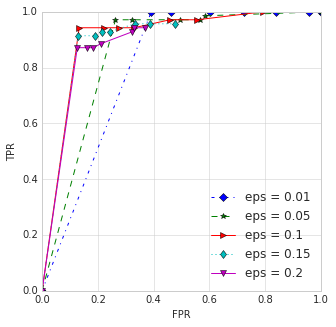

In [43]:
plt.figure(figsize=(5,5))
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.plot(dic[eps_values[0]][1], dic[eps_values[0]][0], ls='-.', label='eps = ' + str(eps_values[0]), marker='D')

plt.plot(dic[eps_values[1]][1], dic[eps_values[1]][0], ls='--', label='eps = '+ str(eps_values[1]), marker='*')

plt.plot(dic[eps_values[2]][1], dic[eps_values[2]][0], ls='-', label='eps = '+ str(eps_values[2]), marker='>')

plt.plot(dic[eps_values[3]][1], dic[eps_values[3]][0], ls=':', label='eps = '+ str(eps_values[3]), marker='d')

plt.plot(dic[eps_values[4]][1], dic[eps_values[4]][0], ls='solid', label='eps = '+ str(eps_values[4]), marker='v')

#plt.plot(dic[eps_values[5]][1], dic[eps_values[5]][0], ls='-.', label='eps = '+ str(eps_values[5]), marker='+')


plt.legend(loc=4)



plt.savefig('./figuras/dbs-eps-tefa.png', format='png',dpi=1000)

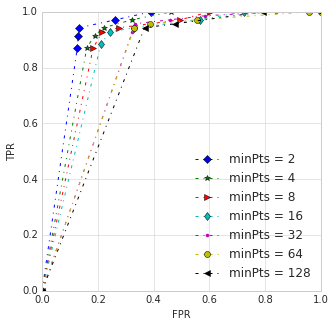

In [44]:
plt.figure(figsize=(5,5))

plt.ylabel('TPR')
plt.xlabel('FPR')


lab = ['minPts = 2','minPts = 4','minPts = 8','minPts = 16','minPts = 32','minPts = 64','minPts = 128']
mark = ['D','*','>','d','.','o','<']

for i  in range(0,7):
    
    x = [0.0, dic[eps_values[0]][1][i+1],dic[eps_values[1]][1][i+1],dic[eps_values[2]][1][i+1],dic[eps_values[3]][1][i+1],dic[eps_values[4]][1][i+1]]
    y = [0.0, dic[eps_values[0]][0][i+1],dic[eps_values[1]][0][i+1],dic[eps_values[2]][0][i+1],dic[eps_values[3]][0][i+1],dic[eps_values[4]][0][i+1]]
       
    x.sort()
    y.sort()
    
    plt.plot(x, y, ls='-.', label=lab[i], marker=mark[i])

plt.legend(loc=4)

plt.savefig('./figuras/dbs-min-tefa.png',format='png',dpi=1000)

In [45]:
minPt = 2
ep = 0.1
n = 1000

In [46]:
eps_ed = [0,0.2,0.4,0.6,1.0,1.5,3]

ks = [1,2,4,8,16,32,64]

k_dic = {}

for k in ks:

    
    tprv = []
    fprv = []
    
    kmodel = MiniBatchKMeans(n_clusters=k,random_state=10, init='k-means++')

    print('--k:', k)
    
    result = run_train(eps_=ep,
                             min_samples_=minPt,
                             E=1, 
                             kmodel=kmodel,
                             chunk_size=n,
                             tau1=0,
                             rd_threshold=0.5,
                             alpha=1.0,
                             tau2=1,
                             adapt=True
                            )
    
    for E in eps_ed:
        
        #Verdadeiro positivo: ED é maior do que o limiar e é ataque
        tp = len(result[(result.KM_ED > E) & (result.classe != False)])

        #Falso negativo: ED é menor que o limiar, mas é ataque
        fn = len(result[(result.KM_ED <= E) & (result.classe != False)])

        #Falso positivo: ED é maior do que o limiar, mas é normal 
        fp = len(result[(result.KM_ED > E) & (result.classe == False)]) 
        
        tpr = tp / qtd_attack
        fpr = fp / qtd_normal
        

        precisao = tp / (tp + fp)
        
        fs = 2 * (precisao * tpr) / (precisao + tpr)
        
        
        print('e:', E,'\t',tpr,'\t',fpr,'\t',fs)

        tprv.append(tpr)
        fprv.append(fpr)
    
    k_dic[k] = (tprv, fprv)
    

--k: 1
e: 0 	 0.9428571428571428 	 0.13294512435846823 	 0.08900876601483479
e: 0.2 	 0.9428571428571428 	 0.13176075799447295 	 0.08973487423521413
e: 0.4 	 0.9 	 0.12149624950651401 	 0.09237536656891496
e: 0.6 	 0.8571428571428571 	 0.10491512041058033 	 0.10058675607711651
e: 1.0 	 0.6285714285714286 	 0.06523884721673905 	 0.1135483870967742
e: 1.5 	 0.4857142857142857 	 0.04579549940781682 	 0.11971830985915494
e: 3 	 0.44285714285714284 	 0.02220686932491117 	 0.19018404907975459
--k: 2
e: 0 	 0.9428571428571428 	 0.13294512435846823 	 0.08900876601483479
e: 0.2 	 0.9285714285714286 	 0.13087248322147652 	 0.08898015058179329
e: 0.4 	 0.9 	 0.11991709435452033 	 0.09347181008902075
e: 0.6 	 0.8571428571428571 	 0.09593367548361627 	 0.10889292196007258
e: 1.0 	 0.6285714285714286 	 0.06464666403474141 	 0.11443433029908971
e: 1.5 	 0.4857142857142857 	 0.045400710619818395 	 0.12056737588652482
e: 3 	 0.44285714285714284 	 0.022009474930911963 	 0.19135802469135804
--k: 4
e: 0 	

In [47]:
with open('dic_kstefa.pkl', 'wb') as pickle_file:
    pickle.dump(k_dic, pickle_file)

In [48]:
with open('dic_kstefa.pkl', 'rb') as pickle_file:
    k_dic = pickle.load(pickle_file)

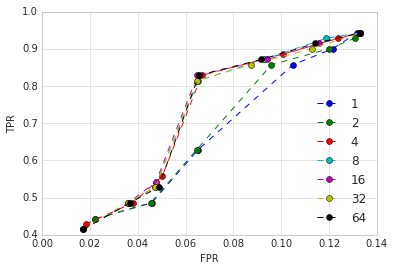

In [49]:
plt.figure()
plt.ylabel('TPR')
plt.xlabel('FPR')


for k in ks:
    x = k_dic[k][1]
    y = k_dic[k][0]
    
    x.sort()
    y.sort()
    
    plt.plot(x,y,label = k, ls='--',marker='o')
    
plt.legend(loc=4)

plt.yticks = [0,0.25,0.5,0.75,1.0]
plt.xticks = [0,0.25,0.5,0.75,1.0]



plt.savefig('./figuras/many-ks.png', dpi=1000)

In [50]:
eps_ed = [0.1,0.2,0.3,0.4,0.5,1.0,1.5,3]
tau1_ = [0,0.2,0.4,0.6,0.8]


E = 0.2

for t in tau1_:
    print ('-- tau1:', t)
    
    kmodel = MiniBatchKMeans(n_clusters=14,random_state=10, init='k-means++')

    result = run_train(eps_=0.1,
                         min_samples_=2,
                         E=0.2, 
                         kmodel=kmodel,
                         chunk_size=n,
                         tau1=t,
                         rd_threshold=0.5,
                         alpha=1.0,
                         tau2=2,
                         adapt=True,
                         fw = False
                        )

    for E in eps_ed:
    
        
        tau2 = 1

        tp = len(result[(result.TEV > E) & (result.classe != False)])
        tpfw = len(result[(result.TEV > tau2) & (result.classe != False)])
        #Falso negativo: ED é menor que o limiar, mas é ataque
        fn = len(result[(result['TEV'] <= E) & (result['TEV'] <= tau2) & (result.classe != False)])

        fw = len(result[(result['TEV'] <= E) & (result['TEV'] > tau2) & (result.classe != False)])

        #Falso positivo: ED é maior do que o limiar, mas é normal 
        fp = len(result[(result['TEV'] > E) & (result.classe == False)])
        
        
        tpr = tp / qtd_attack
        fpr = fp / qtd_normal

        precisao = tp / (tp + fp)

        fs = 2 * (precisao * tpr) / (precisao + tpr)
        
        print('e:', E,'\t',tpr,'\t',fpr,'\t',fs)
    

-- tau1: 0
e: 0.1 	 0.9428571428571428 	 0.1326490327674694 	 0.0891891891891892
e: 0.2 	 0.9428571428571428 	 0.12939202526648244 	 0.09122322045611611
e: 0.3 	 0.9285714285714286 	 0.12564153178049745 	 0.09232954545454544
e: 0.4 	 0.9142857142857143 	 0.11991709435452033 	 0.094885100074129
e: 0.5 	 0.9 	 0.11379786814054481 	 0.09797822706065319
e: 1.0 	 0.8142857142857143 	 0.06622581918673509 	 0.14285714285714288
e: 1.5 	 0.7 	 0.05201342281879195 	 0.15170278637770898
e: 3 	 0.4714285714285714 	 0.0284247927358863 	 0.16879795396419436
-- tau1: 0.2
e: 0.1 	 0.9 	 0.11853533359652586 	 0.0944527736131934
e: 0.2 	 0.9 	 0.11853533359652586 	 0.0944527736131934
e: 0.3 	 0.8857142857142857 	 0.11103434662455586 	 0.09864757358790771
e: 0.4 	 0.8857142857142857 	 0.09761152783260955 	 0.11061552185548618
e: 0.5 	 0.8714285714285714 	 0.08823529411764706 	 0.11902439024390245
e: 1.0 	 0.8142857142857143 	 0.0587248322147651 	 0.15789473684210525
e: 1.5 	 0.5285714285714286 	 0.046979

In [51]:
result[numerical_features].describe()

,total_conn,dist_dstaddr,dist_dstport,duration_avg,src_pkts_avg,src_bytes/pkts,total_dst_null,total_rst
count,10202.000000,1.020200e+04,1.020200e+04,1.020200e+04,1.020200e+04,1.020200e+04,1.020200e+04,1.020200e+04
mean,0.000000,5.293202e-17,-3.482370e-18,1.114358e-17,1.044711e-17,-1.236241e-17,6.964740e-19,-6.268266e-18
std,1.000049,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,-0.133008,-2.648306e-01,-4.252381e-02,-1.168821e-01,-1.047598e-01,-1.767911e-01,-4.298104e-02,-4.366353e-02
25%,-0.133008,-2.648306e-01,-4.252381e-02,-1.168789e-01,-1.047598e-01,-1.193608e-01,-4.298104e-02,-4.366353e-02
50%,-0.100624,-2.648306e-01,-4.252381e-02,-1.164350e-01,-9.930560e-02,-1.042707e-01,-4.298104e-02,-4.366353e-02
75%,-0.068240,-2.648306e-01,-4.252381e-02,-1.009727e-01,-7.748883e-02,1.132252e-02,6.678367e-03,-4.366353e-02
max,64.990650,4.262902e+01,5.131901e+01,3.339281e+01,6.582551e+01,9.479408e+01,9.813366e+01,5.753581e+01


In [52]:
tau1_ = [0.2]

tau2_ = [0,0.1,0.2,0.4,0.6,0.8]



t2_tpr = []
t2_fpr = []
t2_indice = []

E = 1.0


for t1 in tau1_:
    print ('-- tau1:', t1)


    kmodel = MiniBatchKMeans(n_clusters=14,random_state=10, init='k-means++')

    result = run_train(eps_=0.1,
                         min_samples_=2,
                         E=1.0, 
                         kmodel=kmodel,
                         chunk_size=n,
                         tau1=t1,
                         rd_threshold=0.5,
                         alpha=1.0,
                         tau2=1,
                         adapt=True,
                         fw = True
                        )


    t2_tpr = []
    t2_fpr = []
    t2_fwr = []
    t2_indice = []

    for t2 in tau2_:

        tau2 = t1 + t2

        tp = len(result[(result.TEV > E) & (result.classe != False)])
        tpfw = len(result[(result.TEV > tau2) & (result.classe != False)])

        tp = tpfw
        #Falso negativo: ED é menor que o limiar, mas é ataque
        fn = len(result[(result['TEV'] <= E) & (result['TEV'] <= tau2) & (result.classe != False)])

        fw = len(result[(result['TEV'] <= E) & (result['TEV'] > tau2) & (result.classe != False)])

        #Falso positivo: ED é maior do que o limiar, mas é normal 
        fp = len(result[(result['TEV'] > E) & (result.classe == False)])


        tpr = tp / qtd_attack
        fpr = fp / qtd_normal

        fwr = fw / total

        precisao = tp / (tp + fp)

        fs = 2 * (precisao * tpr) / (precisao + tpr)




        print('tau2:', tau2,'\t',tpr,'\t',fpr,'\t',fs, '\t',fwr)
        t2_tpr.append(tpr)
        t2_fpr.append(fpr)
        t2_fwr.append(fwr)
        t2_indice.append(tau2)

-- tau1: 0.2
tau2: 0.2 	 0.9 	 0.0587248322147651 	 0.17307692307692307 	 0.000588119976475201
tau2: 0.30000000000000004 	 0.8857142857142857 	 0.0587248322147651 	 0.17056396148555708 	 0.0004900999803960007
tau2: 0.4 	 0.8857142857142857 	 0.0587248322147651 	 0.17056396148555708 	 0.0004900999803960007
tau2: 0.6000000000000001 	 0.8428571428571429 	 0.0587248322147651 	 0.1629834254143646 	 0.00019603999215840032
tau2: 0.8 	 0.8285714285714286 	 0.0587248322147651 	 0.16044260027662516 	 9.801999607920016e-05
tau2: 1.0 	 0.8142857142857143 	 0.0587248322147651 	 0.15789473684210525 	 0.0


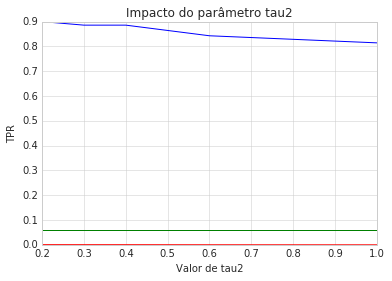

In [53]:
plt.ylabel('TPR')
plt.xlabel('Valor de tau2')
plt.title('Impacto do parâmetro tau2')


plt.plot(t2_indice,t2_tpr)
plt.plot(t2_indice,t2_fpr)
plt.plot(t2_indice,t2_fwr)


plt.legend(loc=4)

plt.show()

In [63]:
kmodel = MiniBatchKMeans(n_clusters=14,random_state=10, init='k-means++')



result = run_train(eps_=0.1,
                     min_samples_=2,
                     E=1.0, 
                     kmodel=kmodel,
                     chunk_size=n,
                     tau1=t1,
                     rd_threshold=0.5,
                     alpha=1.0,
                     tau2=1,
                     adapt=True,
                     fw = True
                    )

In [61]:
E_tev = 1.0
E_ed = 0.4

In [62]:
qtd_normal = len(result[result.classe == False])
qtd_attack = len(result[result.classe == True])


db_tp = len(result[(result.Detect == -1) & (result.classe == True)])
db_fp = len(result[(result.Detect == -1) & (result.classe == False)])

tpr = db_tp /qtd_attack
fpr = db_fp / qtd_normal

precisao = db_tp / (db_tp + db_fp)
fs = 2 * (precisao * tpr) / (precisao + tpr)
print("DBS results:")
print(tpr,'\t',fpr,'\t',fs,'\t',precisao)


#TP
svm_tp = len(result[(result.classe != False) & (result.OneSVM == -1)])
#FP
svm_fp = len(result[(result.classe == False) & (result.OneSVM == -1)])
#FN
svm_fn = len(result[(result.classe != False) & (result.OneSVM != -1)])

tpr = svm_tp /qtd_attack
fpr = svm_fp / qtd_normal

precisao = svm_tp / (svm_tp + svm_fp)
fs = 2 * (precisao * tpr) / (precisao + tpr)
print("DBS-SVM results:")
print(tpr,'\t',fpr,'\t',fs,'\t',precisao)


#Verdadeiro positivo: ED é maior do que o limiar e é ataque
km_ed_tp = len(result[(result.KM_ED > E_ed) & (result.classe != False)])

#Falso negativo: ED é menor que o limiar, mas é ataque
km_ed_fn = len(result[(result.KM_ED <= E_ed) & (result.classe != False)])

#Falso positivo: ED é maior do que o limiar, mas é normal 
km_ed_fp = len(result[(result.KM_ED > E_ed) & (result.classe == False)])    


tpr = km_ed_tp / qtd_attack
fpr = km_ed_fp / qtd_normal

precisao = km_ed_tp / (km_ed_tp + km_ed_fp)
fs = 2 * (precisao * tpr) / (precisao + tpr)
print("KM-ED results:")
print(tpr,'\t',fpr,'\t',fs,'\t',precisao)


km_tev_tp = len(result[(result.TEV > E_tev) & (result.classe != False)])
km_tev_tpfw = len(result[(result.TEV > tau2) & (result.classe != False)])

#Falso negativo: ED é menor que o limiar, mas é ataque
km_tev_fn = len(result[(result['TEV'] <= E_tev) & (result['TEV'] <= tau2) & (result.classe != False)])

km_tev_fw = len(result[(result['TEV'] <= E_tev) & (result['TEV'] > tau2) & (result.classe != False)])

#Falso positivo: ED é maior do que o limiar, mas é normal 
km_tev_fp = len(result[(result['TEV'] > E_tev) & (result.classe == False)])

tpr = km_tev_tpfw / qtd_attack
fpr = km_tev_fp / qtd_normal

fwr = km_tev_fw / total

precisao = km_tev_tpfw / (km_tev_tpfw + km_tev_fp)

fs = 2 * (precisao * tpr) / (precisao + tpr)





tp = len(result[(result.TEV > E) & (result.classe != False)])
tpfw = len(result[(result.TEV > tau2) & (result.classe != False)])

tp = tpfw
#Falso negativo: ED é menor que o limiar, mas é ataque
fn = len(result[(result['TEV'] <= E) & (result['TEV'] <= tau2) & (result.classe != False)])

fw = len(result[(result['TEV'] <= E) & (result['TEV'] > tau2) & (result.classe != False)])

#Falso positivo: ED é maior do que o limiar, mas é normal 
fp = len(result[(result['TEV'] > E) & (result.classe == False)])


tpr = tp / qtd_attack
fpr = fp / qtd_normal

fwr = fw / total

precisao = tp / (tp + fp)

fs = 2 * (precisao * tpr) / (precisao + tpr)




print("TEV results:")
print(tpr,'\t',fpr,'\t',fs,'\t',precisao)



DBS results:
0.9428571428571428 	 0.13294512435846823 	 0.08900876601483479 	 0.04670912951167728
DBS-SVM results:
0.9 	 0.10452033162258192 	 0.10570469798657718 	 0.05614973262032086
KM-ED results:
0.8857142857142857 	 0.10076983813659691 	 0.10754553339115352 	 0.057248384118190214
TEV results:
0.8142857142857143 	 0.0587248322147651 	 0.15789473684210525 	 0.08742331288343558


In [ ]:
#variance = anomaly.groupby('KMcluster')['KM_ED'].std()
#density = []

#for k in range(0, n_clusters_):
        
#    density.append((anomaly[anomaly.KMcluster == k]['KM_ED']).apply(lambda x: math.exp(-x**2/(2*(variance[k]**2)))).sum())
    
#total = anomaly.groupby('KMcluster')['KM_ED'].count()

#print(density / total)

In [ ]:
#density / total

In [ ]:
#KM_limiar

In [81]:
%%timeit total = 10000

result = run_train(eps_=0.1,
                     min_samples_=2,
                     E=1.0, 
                     kmodel=kmodel,
                     chunk_size=n,
                     tau1=t1,
                     rd_threshold=0.5,
                     alpha=1.0,
                     tau2=1,
                     adapt=True,
                     fw = True
                    )

1 loop, best of 3: 5.92 s per loop


In [82]:
%%timeit total = 20000

result = run_train(eps_=0.1,
                     min_samples_=2,
                     E=1.0, 
                     kmodel=kmodel,
                     chunk_size=n,
                     tau1=t1,
                     rd_threshold=0.5,
                     alpha=1.0,
                     tau2=1,
                     adapt=True,
                     fw = True
                    )

1 loop, best of 3: 5.9 s per loop


In [83]:
%%timeit total = 40000

result = run_train(eps_=0.1,
                     min_samples_=2,
                     E=1.0, 
                     kmodel=kmodel,
                     chunk_size=n,
                     tau1=t1,
                     rd_threshold=0.5,
                     alpha=1.0,
                     tau2=1,
                     adapt=True,
                     fw = True
                    )

1 loop, best of 3: 5.9 s per loop


In [84]:
%%timeit total = 80000

result = run_train(eps_=0.1,
                     min_samples_=2,
                     E=1.0, 
                     kmodel=kmodel,
                     chunk_size=n,
                     tau1=t1,
                     rd_threshold=0.5,
                     alpha=1.0,
                     tau2=1,
                     adapt=True,
                     fw = True
                    )

1 loop, best of 3: 5.91 s per loop
